<a href="https://colab.research.google.com/github/femilanab/tail-gan/blob/main/tail_gan_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
# %% [markdown]
# # Tail-aware WGAN-GP (Minimal Tail-GAN) — Colab Notebook
# - Trains on daily log-returns (Yahoo Finance via yfinance)
# - WGAN-GP core with a VaR/ES tail regularizer
# - PEP 8 style, docstrings, small and readable

# %%capture
!pip -q install yfinance pandas numpy matplotlib


In [1]:
!git config --global user.email "femilanab@users.noreply.github.com"
!git config --global user.name "Milan Fejes"

In [9]:
!ls /content/tail-gan/

LICENSE  README.md


In [2]:
!git clone https://github.com/femilanab/tail-gan.git
%cd tail-gan

Cloning into 'tail-gan'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (5/5), done.
/content/tail-gan


In [7]:
!mv /content/tail_gan_colab.ipynb /content/tail-gan

mv: cannot stat '/content/tail_gan_colab.ipynb': No such file or directory


In [ ]:
# %%
from __future__ import annotations

from dataclasses import dataclass
from typing import Optional, Tuple

import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
import yfinance as yf
import matplotlib.pyplot as plt


def set_seed(seed: int = 1) -> None:
    """Set random seeds for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


In [ ]:
# %%
def download_log_returns(
    tickers: list[str],
    start: str = "2015-01-01",
    end: Optional[str] = None,
) -> pd.DataFrame:
    """Download adjusted close prices and return daily log-returns.

    Parameters
    ----------
    tickers : list[str]
        Tickers to download from Yahoo Finance.
    start : str
        Start date (YYYY-MM-DD).
    end : Optional[str]
        End date (YYYY-MM-DD). If None, uses latest.

    Returns
    -------
    pd.DataFrame
        DataFrame of shape (T, D) with daily log-returns. Rows aligned,
        NaN rows dropped.
    """
    data = yf.download(tickers, start=start, end=end, auto_adjust=False, progress=False)
    px = data["Adj Close"].dropna(how="all")
    # Forward-fill minimal gaps, then compute log-returns.
    px = px.ffill()
    logret = np.log(px / px.shift(1)).dropna(how="any")
    return logret


# Small demo universe
tickers = ["SPY", "TLT", "GLD"]  # equity, bonds, gold
logret_df = download_log_returns(tickers, start="2016-01-01")
logret_df.tail()


Ticker,GLD,SPY,TLT
Date,,,
2025-08-28,0.007392,0.003535,0.006557
2025-08-29,0.009604,-0.005982,-0.007134
2025-09-02,0.023367,-0.007438,-0.007469
2025-09-03,0.007801,0.005405,0.010918
2025-09-04,-0.002731,0.003915,0.000000


In [ ]:
# %%
def to_torch(
    df: pd.DataFrame,
    device: torch.device,
    dtype: torch.dtype = torch.float32,
) -> Tensor:
    """Convert a DataFrame to a torch Tensor on device."""
    return torch.tensor(df.values, dtype=dtype, device=device)


def project_portfolio(x: Tensor, w: Optional[Tensor]) -> Tensor:
    """Project samples to 1-D PnL via weights w.

    If x has shape (N, D) and w is (D,), returns (N,).
    If x has shape (N,), returns x.
    """
    if x.dim() == 1:
        return x
    if w is None:
        raise ValueError("Weights must be provided for D > 1.")
    return x @ w


In [ ]:
# %%
@torch.no_grad()
def empirical_var_es(x: Tensor, alpha: float) -> Tuple[Tensor, Tensor]:
    """Empirical (left-tail) VaR and ES at level alpha.

    Parameters
    ----------
    x : Tensor
        1-D tensor of PnL/returns (N,).
    alpha : float
        Tail probability (e.g., 0.01).

    Returns
    -------
    (Tensor, Tensor)
        (VaR_alpha, ES_alpha).
    """
    if x.ndim != 1:
        raise ValueError("x must be 1-D.")
    sorted_x, _ = torch.sort(x)
    n = sorted_x.numel()
    k = max(1, int(alpha * n))
    var_a = sorted_x[k - 1]
    es_a = sorted_x[:k].mean()
    return var_a, es_a


In [ ]:
# %%
class MLP(nn.Module):
    """Simple MLP with LeakyReLU hidden layers."""

    def __init__(self, in_dim: int, out_dim: int, hidden: int = 256, depth: int = 3):
        super().__init__()
        layers = []
        dims = [in_dim] + [hidden] * (depth - 1) + [out_dim]
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            if i < len(dims) - 2:
                layers.append(nn.LeakyReLU(0.2))
        self.net = nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        return self.net(x)


class Generator(nn.Module):
    """Latent z -> return vectors."""

    def __init__(self, z_dim: int, data_dim: int, hidden: int = 256, depth: int = 3):
        super().__init__()
        self.net = MLP(z_dim, data_dim, hidden=hidden, depth=depth)

    def forward(self, z: Tensor) -> Tensor:
        return self.net(z)


class Critic(nn.Module):
    """Wasserstein critic f(x) (no final activation)."""

    def __init__(self, data_dim: int, hidden: int = 256, depth: int = 3):
        super().__init__()
        self.net = MLP(data_dim, 1, hidden=hidden, depth=depth)

    def forward(self, x: Tensor) -> Tensor:
        return self.net(x).squeeze(-1)


In [ ]:
# %%
def gradient_penalty(critic: Critic, real: Tensor, fake: Tensor) -> Tensor:
    """Compute gradient penalty as in WGAN-GP."""
    eps = torch.rand(real.size(0), 1, device=real.device)
    for _ in range(real.dim() - 2):
        eps = eps.unsqueeze(-1)
    interp = eps * real + (1 - eps) * fake
    interp.requires_grad_(True)
    scores = critic(interp)
    grad = torch.autograd.grad(
        outputs=scores,
        inputs=interp,
        grad_outputs=torch.ones_like(scores),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    grad = grad.view(grad.size(0), -1)
    return ((grad.norm(2, dim=1) - 1.0) ** 2).mean()


def tail_penalty(
    gen_samples: Tensor,
    data_var: Tensor,
    data_es: Tensor,
    alpha: float,
    w: Optional[Tensor],
) -> Tensor:
    """Quadratic penalty to match (VaR, ES) of generated PnL to data."""
    pnl = project_portfolio(gen_samples, w)
    # Use detach on statistics to prevent trivial collapse via degenerate gradient flow.
    var_g, es_g = empirical_var_es(pnl, alpha)
    return (var_g - data_var).pow(2) + (es_g - data_es).pow(2)


In [ ]:
# %%
@dataclass
class Config:
    data_dim: int
    z_dim: int = 16
    hidden: int = 256
    depth: int = 3
    batch_size: int = 512
    epochs: int = 800
    lr: float = 1e-4
    critic_steps: int = 5
    gp_lambda: float = 10.0
    alpha: float = 0.01
    tail_lambda: float = 5.0
    device: str = "cpu"  # Colab CPU default; set "cuda" if GPU enabled
    seed: int = 42


def iterate_minibatches(x: Tensor, batch_size: int):
    """Yield shuffled mini-batches from x."""
    n = x.size(0)
    perm = torch.randperm(n, device=x.device)
    for i in range(0, n, batch_size):
        j = min(i + batch_size, n)
        yield x[perm[i:j]]


def train_tail_gan(
    returns: Tensor,
    weights: Optional[Tensor],
    cfg: Config,
) -> tuple[Generator, dict]:
    """Train a minimal Tail-aware WGAN-GP.

    Parameters
    ----------
    returns : Tensor
        Training data of shape (N, D).
    weights : Optional[Tensor]
        Portfolio weights (D,) for tail regularizer projection.
    cfg : Config
        Hyperparameters.

    Returns
    -------
    (Generator, dict)
        Trained generator and training logs.
    """
    device = torch.device(cfg.device if torch.cuda.is_available() else "cpu")
    set_seed(cfg.seed)

    x = returns.to(device).float()
    data_dim = x.size(1)
    if weights is not None:
        weights = (weights / (weights.abs().sum() + 1e-12)).to(device).float()

    # Precompute dataset VaR/ES on portfolio PnL
    with torch.no_grad():
        pnl_data = project_portfolio(x, weights)
        data_var, data_es = empirical_var_es(pnl_data, cfg.alpha)

    G = Generator(cfg.z_dim, data_dim, cfg.hidden, cfg.depth).to(device)
    D = Critic(data_dim, cfg.hidden, cfg.depth).to(device)

    opt_g = optim.Adam(G.parameters(), lr=cfg.lr, betas=(0.5, 0.9))
    opt_d = optim.Adam(D.parameters(), lr=cfg.lr, betas=(0.5, 0.9))

    logs = {"epoch": [], "wgan": [], "tail": [], "var_g": [], "es_g": []}

    for epoch in range(1, cfg.epochs + 1):
        for xb in iterate_minibatches(x, cfg.batch_size):
            # Critic updates
            for _ in range(cfg.critic_steps):
                z = torch.randn(xb.size(0), cfg.z_dim, device=device)
                with torch.no_grad():
                    fake = G(z)
                real_score = D(xb)
                fake_score = D(fake)
                w_dist = fake_score.mean() - real_score.mean()
                gp = gradient_penalty(D, xb, fake)
                loss_d = w_dist + cfg.gp_lambda * gp

                opt_d.zero_grad(set_to_none=True)
                loss_d.backward()
                opt_d.step()

            # Generator update
            z = torch.randn(cfg.batch_size, cfg.z_dim, device=device)
            fake = G(z)
            fake_score = D(fake)
            wgan_loss = -fake_score.mean()

            tpen = tail_penalty(
                gen_samples=fake,
                data_var=data_var.detach(),
                data_es=data_es.detach(),
                alpha=cfg.alpha,
                w=weights,
            )

            loss_g = wgan_loss + cfg.tail_lambda * tpen

            opt_g.zero_grad(set_to_none=True)
            loss_g.backward()
            opt_g.step()

        # Diagnostics every 50 epochs
        if epoch % 50 == 0 or epoch == 1:
            with torch.no_grad():
                z = torch.randn(10000, cfg.z_dim, device=device)
                g = G(z)
                pnl_g = project_portfolio(g, weights)
                var_g, es_g = empirical_var_es(pnl_g, cfg.alpha)

            logs["epoch"].append(epoch)
            logs["wgan"].append(float(wgan_loss.item()))
            logs["tail"].append(float(tpen.item()))
            logs["var_g"].append(float(var_g.item()))
            logs["es_g"].append(float(es_g.item()))

            print(
                f"[{epoch:04d}] WGAN={wgan_loss.item():+.4f}  "
                f"Tail={tpen.item():.6f}  "
                f"VaR_gen={var_g.item():+.5f}  ES_gen={es_g.item():+.5f}  "
                f"(VaR_data={data_var.item():+.5f}, ES_data={data_es.item():+.5f})"
            )

    return G.eval(), logs


In [ ]:
# %%
device = "cuda"  # set to "cuda" if you turn on GPU in Colab runtime
data_t = to_torch(logret_df, device=device)
D = data_t.shape[1]

# Equal-weight portfolio for projection
w = torch.ones(D) / D

cfg = Config(
    data_dim=D,
    z_dim=16,
    hidden=256,
    depth=3,
    batch_size=1024,
    epochs=2500,    # keep small for demo; increase to 1500+ for better fit
    lr=5e-5,
    critic_steps=10,
    gp_lambda=10.0,
    alpha=0.01,
    tail_lambda=8.0,
    device=device,
)

G, logs = train_tail_gan(returns=data_t, weights=w, cfg=cfg)


[0001] WGAN=+0.0600  Tail=0.063625  VaR_gen=-0.19308  ES_gen=-0.21064  (VaR_data=-0.01636, ES_data=-0.02208)
[0050] WGAN=-0.0312  Tail=0.016168  VaR_gen=-0.11029  ES_gen=-0.12534  (VaR_data=-0.01636, ES_data=-0.02208)
[0100] WGAN=-0.1854  Tail=0.016058  VaR_gen=-0.10259  ES_gen=-0.11515  (VaR_data=-0.01636, ES_data=-0.02208)
[0150] WGAN=-0.1453  Tail=0.005385  VaR_gen=-0.07491  ES_gen=-0.08384  (VaR_data=-0.01636, ES_data=-0.02208)
[0200] WGAN=-0.0704  Tail=0.001646  VaR_gen=-0.04907  ES_gen=-0.05663  (VaR_data=-0.01636, ES_data=-0.02208)
[0250] WGAN=-0.2828  Tail=0.003343  VaR_gen=+0.03252  ES_gen=+0.02656  (VaR_data=-0.01636, ES_data=-0.02208)
[0300] WGAN=-0.1118  Tail=0.004275  VaR_gen=-0.06941  ES_gen=-0.08062  (VaR_data=-0.01636, ES_data=-0.02208)
[0350] WGAN=-0.0276  Tail=0.029379  VaR_gen=-0.13254  ES_gen=-0.14523  (VaR_data=-0.01636, ES_data=-0.02208)
[0400] WGAN=-0.0678  Tail=0.000026  VaR_gen=-0.02206  ES_gen=-0.03033  (VaR_data=-0.01636, ES_data=-0.02208)
[0450] WGAN=+0.0303

Real  VaR_1.00%: -0.01636, ES_1.00%: -0.02208
Gen   VaR_1.00%: -0.01083, ES_1.00%: -0.01336


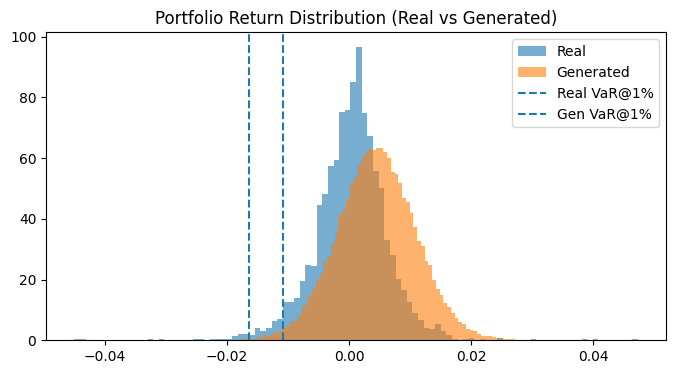

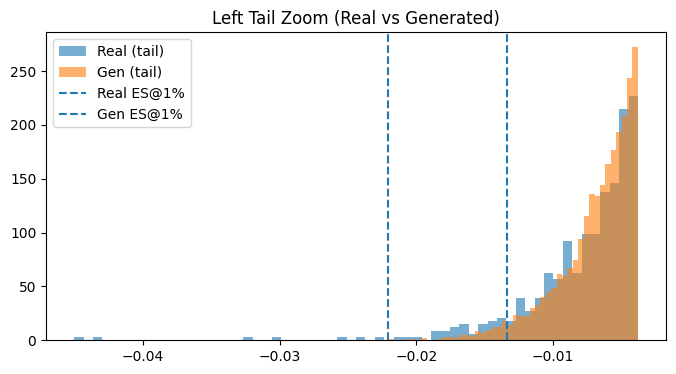

In [ ]:
# %%
@torch.no_grad()
def sample_generator(G: Generator, n: int, z_dim: int, device: torch.device) -> Tensor:
    """Generate n return vectors from the trained generator."""
    z = torch.randn(n, z_dim, device=device)
    return G(z)


# Compare VaR/ES
device_t = torch.device(cfg.device if torch.cuda.is_available() else "cpu")
pnl_real = project_portfolio(data_t.to(device_t), w.to(device_t))
var_r, es_r = empirical_var_es(pnl_real, cfg.alpha)

gen_samples = sample_generator(G, n=50_000, z_dim=cfg.z_dim, device=device_t)
pnl_gen = project_portfolio(gen_samples, w.to(device_t))
var_g, es_g = empirical_var_es(pnl_gen, cfg.alpha)

print(f"Real  VaR_{cfg.alpha:.2%}: {var_r.item():+.5f}, ES_{cfg.alpha:.2%}: {es_r.item():+.5f}")
print(f"Gen   VaR_{cfg.alpha:.2%}: {var_g.item():+.5f}, ES_{cfg.alpha:.2%}: {es_g.item():+.5f}")

# Histograms (center + tail)
plt.figure(figsize=(8, 4))
plt.hist(pnl_real.cpu().numpy(), bins=100, alpha=0.6, density=True, label="Real")
plt.hist(pnl_gen.cpu().numpy(), bins=100, alpha=0.6, density=True, label="Generated")
plt.axvline(var_r.item(), linestyle="--", label=f"Real VaR@{cfg.alpha:.0%}")
plt.axvline(var_g.item(), linestyle="--", label=f"Gen VaR@{cfg.alpha:.0%}")
plt.title("Portfolio Return Distribution (Real vs Generated)")
plt.legend()
plt.show()

# Left-tail zoom
q_cut = np.percentile(pnl_real.cpu().numpy(), 20)  # focus on lower 20%
plt.figure(figsize=(8, 4))
plt.hist(pnl_real.cpu().numpy()[pnl_real.cpu().numpy() <= q_cut], bins=60, density=True, alpha=0.6, label="Real (tail)")
plt.hist(pnl_gen.cpu().numpy()[pnl_gen.cpu().numpy() <= q_cut], bins=60, density=True, alpha=0.6, label="Gen (tail)")
plt.axvline(es_r.item(), linestyle="--", label=f"Real ES@{cfg.alpha:.0%}")
plt.axvline(es_g.item(), linestyle="--", label=f"Gen ES@{cfg.alpha:.0%}")
plt.title("Left Tail Zoom (Real vs Generated)")
plt.legend()
plt.show()
